In [1]:
from glob import glob
import matplotlib.image as mpimg
from skimage import segmentation
import pims
import seaborn as sns
import re
import scipy
import os
import numpy as np
import cv2 as cv
from glob import glob
from tqdm import tqdm #progressbar
import dabest
import pandas as pd
%matplotlib inline
import plotly.express as px
import pickle
from datetime import datetime
import plotly.graph_objects as go
import math

In [2]:
def get_edge(binary_image, pixel_size, image):
    cnt = cv.findContours(~binary_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)[0]
    for k in range(len(cnt)):
        area = cv.contourArea(cnt[k])
        if area>7000:
            # grab the (x, y) coordinates of all border values
            otln = np.squeeze(cnt[k])
            min_x = int(min(otln.T[0]))
            min_y = int(min(otln.T[1]))
            max_x = int(max(otln.T[0]))
            max_y = int(max(otln.T[1]))
            dl=[]
            for j in range(len(otln)):
                if otln.tolist()[j][0] == min_x or otln.tolist()[j][0] == max_x or otln.tolist()[j][1] == min_y or otln.tolist()[j][1] == max_y:
                    dl.append(j)

            # We will than be deleting these values from our contour array so that we are only
            # looking at the monolayer edge boundarys
            rslt = np.delete(otln, dl, 0) 
            edge = rslt*pixel_size # transform from pixel to micron
            
            if image==0:
                # compute a rotated bounding box that contains all coordinates
                box_ang  = cv.minAreaRect(rslt)[-1]

                # the `cv2.minAreaRect` function returns values in the
                # range [-90, 0); as the rectangle rotates clockwise the
                # returned angle trends to 0
                if box_ang > 45:
                    box_ang = (90 - box_ang)
                # otherwise, just take the inverse of the angle to make it positive
                else:
                    box_ang = -box_ang
                return edge, box_ang
            else:
                return edge

In [3]:
def calc_complexity(edge_coords):
    all_dist = []
    for i in range(len(edge_coords)-1):
        #find point a (i) and point b (i+1)
        a = np.array((edge_coords[i][0], edge_coords[i][1]))
        b = np.array((edge_coords[i+1][0], edge_coords[i+1][1]))

        # calculate euclidean distance between point a and point b
        dist = np.linalg.norm(a-b) 
        # append distance between each point to a list
        all_dist.append(dist)
    edge_len = np.sum(all_dist)
    return edge_len

In [78]:
def calc_curvature(edge_coords):
    # Calculate the curvature of the edge as the Menger curvature of points
    # Uses curvature of points within 20 boundary points of the boundary point 
    # of interest. We use curvature of the surrounding X boundary points bc successive
    # boundary points would result in oversampling of data. Function takes array 
    # of x,y coordinates as input. Returns an array of the Menger curvature of points
    meng_first = []
    bound = 40 #this detemines how many of surrounding boundary points we take
    
    for i in range(len(edge_coords)-bound):
        # Find coordinates of 3 data points F, G(a+bound/2), H(a+bound)
        F = np.array((edge_coords[i][0], edge_coords[i][1]))
        G = np.array((edge_coords[i+int(bound/2)][0], edge_coords[i+int(bound/2)][1]))
        H = np.array((edge_coords[i+bound][0], edge_coords[i+bound][1]))
        
        # Calculate Side lengths f,g and h using Cartesian distance formula
        h = np.sqrt(np.square(G[0]-F[0])+np.square(G[1]-F[1]))
        f = np.sqrt(np.square(H[0]-G[0])+np.square(H[1]-G[1]))
        g = np.sqrt(np.square(F[0]-H[0])+np.square(F[1]-H[1]))
        
        # Calculate the area of the triangle using the Shoelace formula
        A = (1/2)*(((G[0]-F[0])*(H[1]-G[1]))-((G[1]-F[1])*(H[1]-G[1])))
        
        # We can then calculate the Menger curvature:
        meng_curv = (4*A)/(f*g*h)
        meng_first.append(meng_curv)

    rev = edge_coords[::-1]
    meng_rev=[]
    for i in range(bound):
        # Find coordinates of 3 data points F, G(a+bound/2), H(a+bound)
        F = np.array((rev[i][0], rev[i][1]))
        G = np.array((rev[i+int(bound/2)][0], rev[i+int(bound/2)][1]))
        H = np.array((rev[i+bound][0], rev[i+bound][1]))
        
        # Calculate Side lengths f,g and h using Cartesian distance formula
        h = np.sqrt(np.square(G[0]-F[0])+np.square(G[1]-F[1]))
        f = np.sqrt(np.square(H[0]-G[0])+np.square(H[1]-G[1]))
        g = np.sqrt(np.square(F[0]-H[0])+np.square(F[1]-H[1]))
        
        # Calculate the area of the triangle using the Shoelace formula
        A = (1/2)*(((G[0]-F[0])*(H[1]-G[1]))-((G[1]-F[1])*(H[1]-G[1])))
        
        # We can then calculate the Menger curvature:
        meng_curv = (4*A)/(f*g*h)
        meng_rev.append(meng_curv)
    all_meng = meng_first+meng_rev[::-1]
    
    return np.array(all_meng)

In [5]:
def rotate_matrix (x, y, angle, x_shift=0, y_shift=0, units="DEGREES"):
    """
    Rotates a point in the xy-plane counterclockwise through an angle about the origin
    https://en.wikipedia.org/wiki/Rotation_matrix
    :param x: x coordinate
    :param y: y coordinate
    :param x_shift: x-axis shift from origin (0, 0)
    :param y_shift: y-axis shift from origin (0, 0)
    :param angle: The rotation angle in degrees
    :param units: DEGREES (default) or RADIANS
    :return: Tuple of rotated x and y
    """

    # Shift to origin (0,0)
    x = x - x_shift
    y = y - y_shift

    # Convert degrees to radians
    if units == "DEGREES":
        angle = math.radians(angle)

    # Rotation matrix multiplication to get rotated x & y
    xr = (x * math.cos(angle)) - (y * math.sin(angle)) + x_shift
    yr = (x * math.sin(angle)) + (y * math.cos(angle)) + y_shift

    return xr, yr

In [6]:
def calc_edge_move(coords, delta_t, angle, draw=False):    
    if angle!=0:
        edge_rotated = []
        for j in range(len(coords)):
            x_r, y_r = rotate_matrix(coords[j].T[0], coords[j].T[1], angle)
            edge = np.concatenate((np.vstack(x_r),np.vstack(y_r)), axis=1)
            edge_rotated.append(edge)
    else:
        edge_rotated=coords
    
    if draw==True:
        plt.plot(coords[0].T[0], coords[0].T[1])
        plt.plot(edge_rotated[0],edge_rotated[0])
        plt.show()
    
    # Given that each line is going to be rotated to adjust for any of variability in edge angle
    # our coordinate systems have varying X positions. To calculate the edge position for a fixed
    # X position we will be taking the X positions for the first image and then using those X coords
    # to interpolate Y at Timepoint E given our XY coordinates at that timepoint.
    X_origin = np.unique(edge_rotated[0].T[0]) # we only care about unique X points
    taco = pd.DataFrame(data = {'X0':X_origin})
    for e in range(len(edge_rotated)):
        df = pd.DataFrame({'x':edge_rotated[e].T[0], 'y':edge_rotated[e].T[1]})
        edge_max = df.groupby('x').max() # we want to find the max Y points for a given X
        edge_max.reset_index(inplace = True) # transform back to numpy (probably easier way to do this oh well)
        edge_mx_np = pd.DataFrame.to_numpy(edge_max)
        Y_interp = np.interp(X_origin, edge_mx_np.T[0], edge_mx_np.T[1]) # interpolates Y at positions X0 given XY at timepoint e
        y_val = pd.DataFrame(data = {e:Y_interp}) # makes interpolated values a dataframe
        taco = pd.concat([taco, y_val], axis = 1) # concatenates interpolated Y values to our OG DF
    taco.set_index('X0', inplace = True) # sets the index as the xvalues as index
    
    # Calculate the difference in edge position at each region aka distance traveled btwn frames
    edge_dist = pd.DataFrame()
    for i in range(1, taco.shape[1]):
        diff = taco[i]-taco[i-1] # distance would just be the difference between column at Ti and Ti-1 since we arent moving X positions
        diff_df = pd.DataFrame(data={i:diff})
        edge_dist = pd.concat([edge_dist, diff_df],axis=1)
    
    # Since the formula for speed is d/t we can also get velocity at each point
    edge_vel = edge_dist/delta_t
    
    return edge_dist, edge_vel, edge_rotated

In [60]:
# Set the pixelsize
pixel_size= 0.6442*4
# Set the timestep in minutes between frames
delta_t = 5

# Set which basefolder to cycle through for analysis
# folder="F:/Jesse/cKO/cKO_PIV_less/"
# folder = "F:/Jesse/tdTomato+Drug/Yoda1_PIV/"
folder="F:/Jesse/GoF/GoF_PIV/"

binary_list =  sorted(glob(os.path.join(folder,"Binary", "*.tif")))

edge_dist_dict = {}
edge_speed_dict = {}
edge_coords_dict = {}
edge_curvature_dict = {}
edge_length_dict = {}
rotated_coords={}

for i in tqdm(range(len(binary_list)), position=0, leave=True):
    
    'General Housekeeping:'
    # Grab the filename from filepath for later use
    sfx = binary_list[i].split('\\')
    file_name = sfx[-1][:-4] 
    
    binary_image = pims.TiffStack(binary_list[i]) # Import binary image mask[i]
    
    # Create empty arrays for Edge Characteristics to be appended to
    curvature = []
    complexity = []
    edge_coords = []
    angles=[]
    'Calculate Complexity (Edge Length) and Edge Curvature'
    for image in tqdm(range(len(binary_image)), position=0, leave=True):
        if image==0:
            edge_a, ang = get_edge(binary_image[image], pixel_size, image) #converts units to um here
        else:
            edge_a = get_edge(binary_image[image], pixel_size, image) #converts units to um here
        cmplx = calc_complexity(edge_a)
        edge_coords.append(edge_a)
        complexity.append(cmplx)
        curvature.append(crv)
        
    
    'Calculate Edge Speed and Distance at each unique X Point'
    dist, speed, edge_rotated = calc_edge_move(edge_coords, delta_t, ang, draw=False)
    
    edge_dist_dict.update({file_name : dist})
    edge_speed_dict.update({file_name : speed})
    edge_curvature_dict.update({file_name : curvature})
    edge_length_dict.update({file_name : complexity})
    edge_coords_dict.update({file_name : edge_coords})
    rotated_coords.update({file_name: edge_rotated})

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [08:01<00:00,  1.60s/it]


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [7:54:08<00:00, 254.01s/it]


In [16]:
edge_dist_dict = {}
edge_speed_dict = {}

key_hole = list(rotated_coords.keys())
for k in range(len(key_hole)):
    dist, speed, edge_rotated = calc_edge_move(rotated_coords[key_hole[k]], 5, 0, draw=False)
    edge_dist_dict.update({key_hole[k] : dist})
    edge_speed_dict.update({key_hole[k] : speed})

In [101]:
edge_curvature_dict = {}

key_hole = list(rotated_coords.keys())
for k in range(len(key_hole)):
    curv=[]
    for im in range(len(rotated_coords[key_hole[k]])):
        j = calc_curvature(rotated_coords[key_hole[k]][im])
        curv.append(j)
    edge_curvature_dict.update({key_hole[k] : curv})


C:\Users\17605\.conda\envs\piv\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\17605\.conda\envs\piv\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning:

invalid value encountered in double_scalars



In [448]:
# Save dictionaries as pickle files

date = datetime.now().strftime("%Y_%m_%d_")
pickle.dump(edge_dist_dict, open(f"{date}conVcKO_edge_dist_dict.p", "wb"))
pickle.dump(edge_speed_dict, open(f"{date}conVcKO_edge_speed_dict.p", "wb"))
pickle.dump(edge_curvature_dict, open(f"{date}conVcKO_edge_curvature_dict.p", "wb"))
pickle.dump(edge_length_dict, open(f"{date}conVcKO_edge_length_dict.p", "wb"))
pickle.dump(edge_coords_dict, open(f"{date}conVcKO_edge_coords_dict.p", "wb"))
pickle.dump(rotated_coords, open(f"{date}conVcKO_edge_coords_rotated_dict.p", "wb"))


In [106]:
# Load dictionaries as pickle files
edge_curvature_dict = pickle.load(open("2022_04_24_conVcKO_edge_curvature_dict.p", "rb"))
rotated_coords = pickle.load(open("2022_04_24_conVcKO_edge_coords_rotated_dict.p", "rb"))
edge_coords_dict = pickle.load(open("2022_04_24_conVcKO_edge_coords_dict.p", "rb"))
edge_length_dict = pickle.load(open("2022_04_24_conVcKO_edge_length_dict.p", "rb"))
edge_dist_dict = pickle.load(open("2022_05_03_conVcKO_edge_dist_dict.p", "rb"))
edge_speed_dict = pickle.load(open("2022_05_03_conVcKO_edge_speed_dict.p", "rb"))


In [107]:
cKO_name=[]
Con_name=[]

# standard deviation of edge length over time is the edge variability
Con_cKO_edge_var = []
cKO_edge_var = []

# mean edge length over time is used as a measure of the edge complexity
Con_cKO_edge_avg = []
Con_cKO_edge_avg_norm = []
Con_cKO_edge_last = []

cKO_edge_avg = []
cKO_edge_avg_norm = []
cKO_edge_last = []

key_hole = list(edge_length_dict.keys())
for k in range(len(key_hole)):
    # norm end edge length to edge length of start
    last = edge_length_dict[key_hole[k]][-1]/edge_length_dict[key_hole[k]][0]
    if key_hole[k].split('_')[-2]=='cKO' or key_hole[k].split('_')[-2]=='Skin8' or key_hole[k].split('_')[-4]=='cKO':
        cKO_edge_last.append(last)
        cKO_name.append(key_hole[k])
    elif key_hole[k].split('_')[-2]=='Con' or key_hole[k].split('_')[-4]=='Con':
        Con_cKO_edge_last.append(last)
        Con_name.append(key_hole[k])
        Con_cKO_edge_var
    else:
        print(key_hole[k])
        raise ValueError('Genotype mismatch')

In [84]:
cko_edge_avg=pd.concat([pd.DataFrame(Con_name, columns=['Filename']),
                        pd.DataFrame(Con_cKO_edge_last, columns=['Control(cKO)']),
                        pd.DataFrame(cKO_name, columns=['Filename']),
                        pd.DataFrame(cKO_edge_last, columns=['cKO'])], axis=1)
cko_edge_avg.to_excel('cKO_v_Con_Edge_Length.xlsx')

In [85]:
cko_edge_avg_df=pd.concat([pd.DataFrame(Con_cKO_edge_last, columns=['Control(cKO)']),
                      pd.DataFrame(cKO_edge_last, columns=['cKO'])], axis=1)
edge_avg_dabest = dabest.load(cko_edge_avg_df, idx=("Control(cKO)", "cKO"), resamples=5000)
edge_avg_dabest.cohens_d

DABEST v0.3.1
             
Good morning!
The current time is Wed Jun 22 10:47:48 2022.

The unpaired Cohen's d between Control(cKO) and cKO is 0.598 [95%CI 0.233, 0.952].
The p-value of the two-sided permutation t-test is 0.0012. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

C:\Users\17605\.conda\envs\piv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



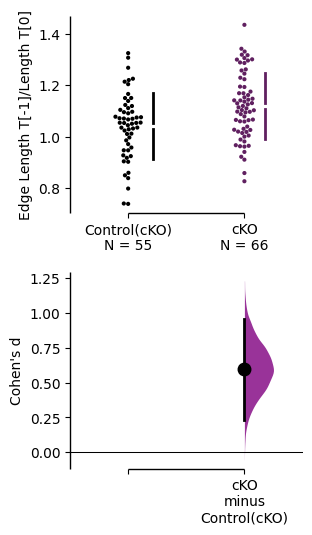

In [86]:
color_pal={'Control(cKO)':'black', 'cKO': 'purple'}
edge_avg_dabest.cohens_d.plot(swarm_label='Edge Length T[-1]/Length T[0]',float_contrast=False, custom_palette=color_pal, raw_marker_size=3);

In [87]:
edge_avg_dabest.cohens_d.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Control(cKO),cKO,55,66,Cohen's d,False,0.597928,95,0.233187,0.952435,0.0012,0.001385,-3.277178,0.001384,-3.274988,0.002981,1244.0


In [90]:
Con_cKO_meng = []
cKO_meng = []
cKO_names = []
Con_cKO_names = []

key_hole = list(edge_curvature_dict.keys())
for k in range(len(key_hole)):
    if key_hole[k].split('_')[-2]=='cKO' or key_hole[k].split('_')[-2]=='Skin8' or key_hole[k].split('_')[-4]=='cKO':
        cKO_meng.append(np.nanmedian(np.absolute(np.concatenate(edge_curvature_dict[key_hole[k]]))))
        cKO_names.append(key_hole[k])
    elif key_hole[k].split('_')[-2]=='Con' or key_hole[k].split('_')[-4]=='Con':
        Con_cKO_meng.append(np.nanmedian(np.absolute(np.concatenate(edge_curvature_dict[key_hole[k]]))))
        Con_cKO_names.append(key_hole[k])
    else:
        print(key_hole[k])
        raise ValueError('Genotype mismatch')

In [91]:
cKO_meng_avg_df = pd.concat([pd.DataFrame(Con_cKO_meng, columns=['Con']),
                      pd.DataFrame(cKO_meng, columns=['cKO'])], axis=1)
cKO_meng_avg_dabest = dabest.load(cKO_meng_avg_df, idx=("Con", "cKO"), resamples=5000)
cKO_meng_avg_dabest.cohens_d

DABEST v0.3.1
             
Good morning!
The current time is Wed Jun 22 10:50:04 2022.

The unpaired Cohen's d between Con and cKO is -0.52 [95%CI -0.906, -0.134].
The p-value of the two-sided permutation t-test is 0.0052. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

In [92]:
cKO_meng_avg = pd.concat([pd.DataFrame(Con_cKO_names, columns=['Filename']),
                        pd.DataFrame(Con_cKO_meng, columns=['Con']),
                        pd.DataFrame(cKO_names, columns=['Filename']),
                        pd.DataFrame(cKO_meng, columns=['cKO'])], axis=1)
date = datetime.now().strftime("%Y_%m_%d_")
cKO_meng_avg.to_excel(f'{date}Con&cKO_Meng_Avg.xlsx')

C:\Users\17605\.conda\envs\piv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



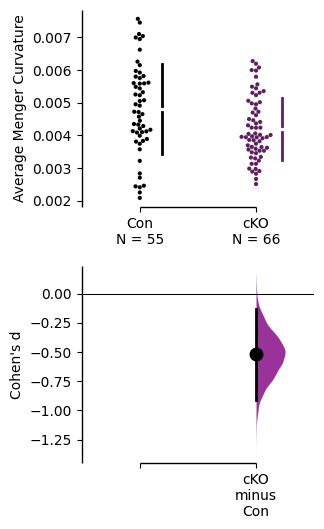

In [93]:
color_pal={'Con':'black', 'cKO': 'purple'}
cKO_meng_avg_dabest.cohens_d.plot(swarm_label='Average Menger Curvature',float_contrast=False, custom_palette=color_pal, raw_marker_size=3);

Edge Dist analysis

In [16]:
# for loop which loops over a edge dist plot dictionary and creates heatmap for each FOV
date = datetime.now().strftime("%Y_%m_%d_")

key_hole = list(edge_dist_dict.keys())
for k in range(len(key_hole)):
    fname = key_hole[k]
    data = edge_dist_dict[fname]
    fig = px.imshow(edge_dist_dict[fname], 
                    aspect = "auto", 
                    color_continuous_scale = 'RdBu_r', 
                    range_color = [-5,5],
                    title = fname,
                    labels=dict(x="Time (frame)", y="Edge Position (um)", color="Dist. (um)")
                   )
    fig.update_layout(
        showlegend=False,
        font=dict(
        size=15),
        margin=dict(t=70,l=50,b=50,r=50)
    )
    fig.write_image(f"{date}_{fname}_Dist_Heatmap.png")

In [449]:
Con_keys=[]
cKO_keys=[]
for k in range(len(key_hole)):
    if key_hole[k].split('_')[-2]=='cKO' or key_hole[k].split('_')[-2]=='Skin8' or key_hole[k].split('_')[-4]=='cKO':
        cKO_keys.append(key_hole[k])
    elif key_hole[k].split('_')[-2]=='Con' or key_hole[k].split('_')[-4]=='Con':
        Con_keys.append(key_hole[k])
    else:
        print(key_hole[k])
        raise ValueError('Genotype mismatch')

In [456]:
for k in range(len(cKO_keys)-1):
    if k==0:
        cKO_edge_stack = np.vstack([np.array(edge_dist_dict[cKO_keys[k]]), np.array(edge_dist_dict[cKO_keys[k+1]])])
    else:
        cKO_edge_stack = np.vstack([cKO_edge_stack, np.array(edge_dist_dict[cKO_keys[k+1]])[:,0:199]])
        
for k in range(len(Con_keys)-1):
    if k==0:
        Con_cKO_edge_stack = np.vstack([np.array(edge_dist_dict[Con_keys[k]]), np.array(edge_dist_dict[Con_keys[k+1]])])
    else:
        Con_cKO_edge_stack = np.vstack([Con_cKO_edge_stack, np.array(edge_dist_dict[Con_keys[k+1]])[:,0:199]])

In [459]:
date = datetime.now().strftime("%Y_%m_%d_")

Con_cKO_Edge_dist = pd.DataFrame(Con_cKO_edge_stack)
cKO_Edge_dist = pd.DataFrame(cKO_edge_stack)
Con_cKO_Edge_dist.to_excel(f'{date}Con(cKO)_EdgeDistance.xlsx')
cKO_Edge_dist.to_excel(f'{date}cKO_EdgeDistance.xlsx')

In [395]:
fig = px.imshow(Con_cKO_edge_stack, 
                aspect = "auto", 
                color_continuous_scale = 'RdBu_r', 
                range_color = [-5,5],
                title = 'Control All Stacked',
                labels=dict(x="Time (frame)", y="Edge Position (um)", color="Dist. (um)")
               )
fig.update_layout(
    showlegend=False,
    font=dict(
    size=15),
    margin=dict(t=70,l=50,b=50,r=50)
)
date = datetime.now().strftime("%Y_%m_%d_")
fig.write_image(f"{date}_ControlAll_Dist_Heatmap.png")

In [102]:
key_hole = list(edge_coords_dict.keys())
date = datetime.now().strftime("%Y_%m_%d_")

for k in range(len(key_hole)):
    stack = pd.DataFrame()
    fname = key_hole[k]
    data = edge_coords_dict[fname]
    cv = -pd.DataFrame.transpose(pd.DataFrame(edge_curvature_dict[fname]))
    for i in range(len(data)):
        df = pd.DataFrame(data[i], columns=['x','y'])
        df.insert(loc=0, column='Curve', value=cv[i])
        stack = pd.concat([stack, df])
    fig = go.Figure()
    fig = px.scatter(stack,
                     x = "x",
                     y = "y",
                     title = fname,
                     range_x = [0,1480],
                     range_y = [0,1480],
                     range_color = [-0.02, 0.02],
                     color = 'Curve',
                     color_continuous_scale  = "Tropic",
                     labels = {"Frame#":"Frame"},
                     height = 1325,
                     width = 2880
                    )
    fig.update_layout(
        showlegend=False,
        font=dict(
        size=25),
        margin=dict(t=70,l=50,b=50,r=50)
    )
    fig.update_traces(marker_size=10)
    fig.write_image(f"{date}{fname}_CurveContour.png")
    fig.write_image(f"{date}{fname}_CurveContour.svg")

In [249]:
cKO_curve={}
Con_cKO_curve={}
key_hole = list(edge_curvature_dict.keys())
for k in range(len(key_hole)):
    for j in range(len(edge_curvature_dict[key_hole[k]])):
        if key_hole[k].split('_')[-2]=='cKO' or key_hole[k].split('_')[-2]=='Skin8' or key_hole[k].split('_')[-4]=='cKO':
            cKO_curve.update({key_hole[k] : edge_curvature_dict[key_hole[k]]})
        elif key_hole[k].split('_')[-2]=='Con' or key_hole[k].split('_')[-4]=='Con':
            Con_cKO_curve.update({key_hole[k] : edge_curvature_dict[key_hole[k]]})
        else:
            print(key_hole[k])
            raise ValueError('Genotype mismatch')

In [341]:
# Create heatmap plots of just the menger curvature values

key_hole = list(Con_cKO_curve.keys())
date = datetime.now().strftime("%Y_%m_%d_")

for k in range(len(key_hole)):
    fname=key_hole[k]
    fig = px.imshow(pd.DataFrame.transpose(pd.DataFrame(Con_cKO_curve[fname])), 
                aspect = "auto", 
                color_continuous_scale = 'RdBu_r',
                range_color = [-0.05,0.05],
#                 color = "Distance (μm)",
                title = fname
#                 x = key_hole[0]
               )
    fig.write_html(f'{date}{fname}_curvature.html', auto_open=False)
    break

    
key_hole = list(cKO_curve.keys())
date = datetime.now().strftime("%Y_%m_%d_")

for k in range(len(key_hole)):
    fname=key_hole[k]
    fig = px.imshow(pd.DataFrame.transpose(pd.DataFrame(cKO_curve[fname])), 
                aspect = "auto", 
                color_continuous_scale = 'RdBu_r',
                range_color = [-0.05,0.05],
#                 color = "Distance (μm)",
                title = fname
#                 x = key_hole[0]
               )
    fig.write_html(f'{date}{fname}_curvature.html', auto_open=False)
    break

In [ ]:
# for loop which loops over a contour plot dictionary and creates plots for each FOV
# Each Plot plots contour over the course of an imaging period

key_hole = list(edge_coords_dict.keys())
for k in range(len(key_hole)):
    stack = pd.DataFrame()
    fname = key_hole[k]
    data = edge_coords_dict[fname]
    for i in range(len(data)):
        df = pd.DataFrame(data[i], columns=['x','y'])
        df.insert(loc=0,column='Frame#', value=i, allow_duplicates=True)
        stack = pd.concat([stack, df])
    fig = go.Figure()
    fig = px.scatter(stack,
                     x="x",
                     y="y",
                     title=fname,
                     range_x=[0,1480],
                     range_y=[0,1480],
                     color="Frame#",
                     color_continuous_scale  = "Plasma_r",
                     labels={"Frame#":"Frame"},
                     height=1325,
                     width=2880
                    )
    fig.update_layout(
        showlegend=False,
        font=dict(
        size=25),
        margin=dict(t=70,l=50,b=50,r=50)
    )
    fig.update_traces(marker_size=14)
    fig.write_image(f"{fname}_ContourPlot.png")
    fig.write_image(f"{fname}_ContourPlot.svg")

In [135]:
stack = pd.DataFrame()
data = edge_coords_dict['317_2021_03_27_batch66_Pos13_cKO_bot']
for i in range(len(data)):
    df = pd.DataFrame(data[i], columns=['x','y'])
    df.insert(loc=0,column='Frame#', value=i, allow_duplicates=True)
    stack = pd.concat([stack, df])
fig = px.scatter(stack,
                 x="x",
                 y="y",
                 title=fname,
                 range_x=[0,1480],
#                  range_y=[0,800],
                 color="Frame#",
                 color_continuous_scale  = "Plasma_r",
                 labels={"Frame#":"Frame"},
                 height=1325,
                 width=2880
                )
fig.update_layout(
    showlegend=False,
    font=dict(
    size=25),
    margin=dict(t=60,l=50,b=50,r=50)
)
fig.update_traces(marker_size=14)

fig.write_html('test.html', auto_open=True)

In [167]:
stack = pd.DataFrame()
data=edge_coords_dict['317_2021_03_27_batch66_Pos27_Con_top']
for i in range(len(data)):
    df = pd.DataFrame(data[i], columns=['x','y'])
#     df.insert(loc=0,column='Frame#', value=i, allow_duplicates=True)
    stack = pd.concat([stack, df],axis=1)
    
stack.to_excel('317_2021_03_27_batch66_Pos27_Con_top.xlsx')

DMSO & Yoda1

In [31]:
# Save dictionaries as pickle files
date = datetime.now().strftime("%Y_%m_%d_")
pickle.dump(edge_dist_dict, open(f"{date}DMSO&Yoda1_edge_dist_dict.p", "wb"))
pickle.dump(edge_speed_dict, open(f"{date}DMSO&Yoda1_edge_speed_dict.p", "wb"))
pickle.dump(edge_curvature_dict, open(f"{date}DMSO&Yoda1_edge_curvature_dict.p", "wb"))
pickle.dump(edge_length_dict, open(f"{date}DMSO&Yoda1_edge_length_dict.p", "wb"))
pickle.dump(edge_coords_dict, open(f"{date}DMSO&Yoda1_edge_coords_dict.p", "wb"))
pickle.dump(rotated_coords, open(f"{date}DMSO&Yoda1_edge_coords_rotated_dict.p", "wb"))


In [104]:
# Load dictionaries as pickle files
edge_curvature_dict = pickle.load(open("2022_05_26_DMSO&Yoda1_edge_curvature_dict.p", "rb"))
rotated_coords = pickle.load(open("2022_05_26_DMSO&Yoda1_edge_coords_rotated_dict.p", "rb"))
edge_coords_dict = pickle.load(open("2022_05_26_DMSO&Yoda1_edge_coords_dict.p", "rb"))
edge_length_dict = pickle.load(open("2022_05_26_DMSO&Yoda1_edge_length_dict.p", "rb"))
edge_dist_dict = pickle.load(open("2022_05_26_DMSO&Yoda1_edge_dist_dict.p", "rb"))
edge_speed_dict = pickle.load(open("2022_05_26_DMSO&Yoda1_edge_speed_dict.p", "rb"))


In [105]:
DMSO_name=[]
Yoda1_name=[]

# standard deviation of edge length over time is the edge variability
DMSO_edge_var = []
Yoda1_edge_var = []

# mean edge length over time is used as a measure of the edge complexity
DMSO_edge_avg = []
DMSO_edge_avg_norm = []
DMSO_edge_last = []

Yoda1_edge_avg = []
Yoda1_edge_avg_norm = []
Yoda1_edge_last = []

key_hole = list(edge_length_dict.keys())
for k in range(len(key_hole)):
    #norm to starting length of scratch
    last = edge_length_dict[key_hole[k]][-1]/edge_length_dict[key_hole[k]][0]
    if key_hole[k].split('_')[-4]=='Yoda1' or key_hole[k].split('_')[-2]=='Yoda1' or key_hole[k].split('_')[-2]=='Y1' or key_hole[k].split('_')[-3]=='Yoda1':
        Yoda1_edge_last.append(last)
        Yoda1_name.append(key_hole[k])
    elif key_hole[k].split('_')[-2]=='DMSO' or key_hole[k].split('_')[-3]=='DMSO':
        DMSO_edge_last.append(last)
        DMSO_name.append(key_hole[k])
    else:
        print(key_hole[k])
        raise ValueError('Genotype mismatch')

In [34]:
DMSO_edge_avg=pd.concat([pd.DataFrame(DMSO_name, columns=['Filename']),
                        pd.DataFrame(DMSO_edge_last, columns=['DMSO']),
                        pd.DataFrame(Yoda1_name, columns=['Filename']),
                        pd.DataFrame(Yoda1_edge_last, columns=['Yoda1'])], axis=1)
DMSO_edge_avg.to_excel('DMSO_v_Yoda1_Edge_Length.xlsx')

In [35]:
DMSO_edge_avg_df = pd.concat([pd.DataFrame(DMSO_edge_last, columns=['DMSO']),
                      pd.DataFrame(Yoda1_edge_last, columns=['Yoda1'])], axis=1)
edge_avg_dabest = dabest.load(DMSO_edge_avg_df, idx=("DMSO", "Yoda1"), resamples=5000)
edge_avg_dabest.cohens_d

DABEST v0.3.1
             
Good morning!
The current time is Thu May 26 06:25:48 2022.

The unpaired Cohen's d between DMSO and Yoda1 is -0.873 [95%CI -1.27, -0.416].
The p-value of the two-sided permutation t-test is 0.0002. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

C:\Users\17605\.conda\envs\piv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



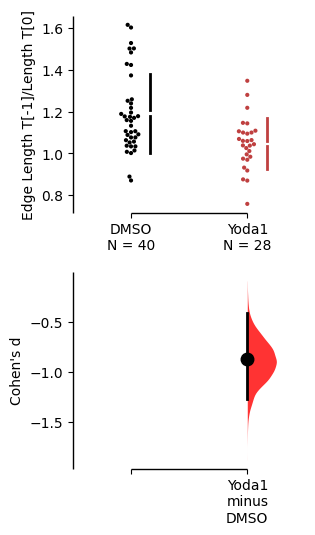

In [36]:
color_pal={'DMSO':'black', 'Yoda1': 'red'}
edge_avg_dabest.cohens_d.plot(swarm_label='Edge Length T[-1]/Length T[0]',float_contrast=False, custom_palette=color_pal, raw_marker_size=3);

In [56]:
DMSO_meng = []
Yoda1_meng = []
DMSO_names = []
Yoda1_names = []

key_hole = list(edge_curvature_dict.keys())
for k in range(len(key_hole)):
    if key_hole[k].split('_')[-2]=='DMSO' or key_hole[k].split('_')[-3]=='DMSO':
        DMSO_meng.append(np.nanmedian(np.absolute(np.concatenate(edge_curvature_dict[key_hole[k]]))))
        DMSO_names.append(key_hole[k])
    elif key_hole[k].split('_')[-4]=='Yoda1' or key_hole[k].split('_')[-2]=='Yoda1' or key_hole[k].split('_')[-2]=='Y1' or key_hole[k].split('_')[-3]=='Yoda1':
        Yoda1_meng.append(np.nanmedian(np.absolute(np.concatenate(edge_curvature_dict[key_hole[k]]))))
        Yoda1_names.append(key_hole[k])
    else:
        print(key_hole[k])
        raise ValueError('Genotype mismatch')

In [57]:
DMSOYoda1_avg_df = pd.concat([pd.DataFrame(DMSO_meng, columns=['DMSO']),
                      pd.DataFrame(Yoda1_meng, columns=['Yoda1'])], axis=1)
Yoda1_meng_avg_dabest = dabest.load(DMSOYoda1_avg_df, idx=("DMSO", "Yoda1"), resamples=5000)
Yoda1_meng_avg_dabest.cohens_d

DABEST v0.3.1
             
Good evening!
The current time is Sat Jun 18 12:28:35 2022.

The unpaired Cohen's d between DMSO and Yoda1 is -0.427 [95%CI -0.884, 0.134].
The p-value of the two-sided permutation t-test is 0.0796. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

In [58]:
Yoda1_meng_avg = pd.concat([pd.DataFrame(DMSO_names, columns=['Filename']),
                        pd.DataFrame(DMSO_meng, columns=['DMSO']),
                        pd.DataFrame(Yoda1_names, columns=['Filename']),
                        pd.DataFrame(Yoda1_meng, columns=['Yoda1'])], axis=1)
date = datetime.now().strftime("%Y_%m_%d_")
Yoda1_meng_avg.to_excel(f'{date}DMSO&Yoda1_Meng_Avg.xlsx')

C:\Users\17605\.conda\envs\piv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


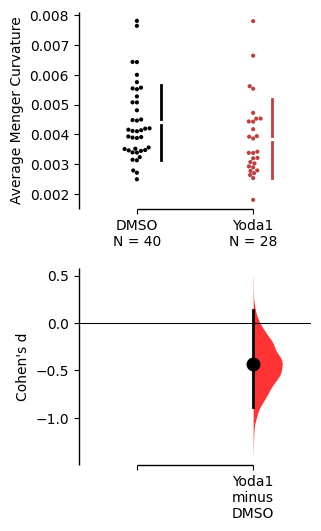

In [59]:
color_pal={'DMSO':'black', 'Yoda1': 'red'}
Yoda1_meng_avg_dabest.cohens_d.plot(swarm_label='Average Menger Curvature',float_contrast=False, custom_palette=color_pal, raw_marker_size=3);

Con & GoF

In [61]:
# Save dictionaries as pickle files
date = datetime.now().strftime("%Y_%m_%d_")
pickle.dump(edge_dist_dict, open(f"{date}Con&GoF_edge_dist_dict.p", "wb"))
pickle.dump(edge_speed_dict, open(f"{date}Con&GoF_edge_speed_dict.p", "wb"))
pickle.dump(edge_curvature_dict, open(f"{date}Con&GoF_edge_curvature_dict.p", "wb"))
pickle.dump(edge_length_dict, open(f"{date}Con&GoF_edge_length_dict.p", "wb"))
pickle.dump(edge_coords_dict, open(f"{date}Con&GoF_edge_coords_dict.p", "wb"))
pickle.dump(rotated_coords, open(f"{date}Con&GoF_edge_coords_rotated_dict.p", "wb"))


In [110]:
# Load dictionaries as pickle files
edge_curvature_dict = pickle.load(open("2022_06_19_Con&GoF_edge_curvature_dict.p", "rb"))
rotated_coords = pickle.load(open("2022_06_19_Con&GoF_edge_coords_rotated_dict.p", "rb"))
edge_coords_dict = pickle.load(open("2022_06_19_Con&GoF_edge_coords_dict.p", "rb"))
edge_length_dict = pickle.load(open("2022_06_19_Con&GoF_edge_length_dict.p", "rb"))
edge_dist_dict = pickle.load(open("2022_06_19_Con&GoF_edge_dist_dict.p", "rb"))
edge_speed_dict = pickle.load(open("2022_06_19_Con&GoF_edge_speed_dict.p", "rb"))


In [111]:
ConGoF_name=[]
GoF_name=[]

# standard deviation of edge length over time is the edge variability
ConGoF_edge_var = []
GoF_edge_var = []

# mean edge length over time is used as a measure of the edge complexity
ConGoF_edge_avg = []
ConGoF_edge_avg_norm = []
ConGoF_edge_last = []

GoF_edge_avg = []
GoF_edge_avg_norm = []
GoF_edge_last = []

key_hole = list(edge_length_dict.keys())
for k in range(len(key_hole)):
    #norm to starting length of scratch
    last = edge_length_dict[key_hole[k]][-1]/edge_length_dict[key_hole[k]][0]
    if key_hole[k].split('_')[-2]=='GoF':
        GoF_edge_last.append(last)
        GoF_name.append(key_hole[k])
    elif key_hole[k].split('_')[-2]=='Con':
        ConGoF_edge_last.append(last)
        ConGoF_name.append(key_hole[k])
    else:
        print(key_hole[k])
        raise ValueError('Genotype mismatch')

In [26]:
GoF_edge_avg = pd.concat([pd.DataFrame(ConGoF_name, columns=['Filename']),
                        pd.DataFrame(ConGoF_edge_last, columns=['Con']),
                        pd.DataFrame(GoF_name, columns=['Filename']),
                        pd.DataFrame(GoF_edge_last, columns=['GoF'])], axis=1)
date = datetime.now().strftime("%Y_%m_%d_")
GoF_edge_avg.to_excel(f'{date}Con&GoF_Edge_Length.xlsx')

In [118]:
del ConGoF_edge_last[12]

In [109]:
GoF_edge_avg_df = pd.concat([pd.DataFrame(ConGoF_edge_last, columns=['Con']),
                      pd.DataFrame(GoF_edge_last, columns=['GoF'])], axis=1)
edge_avg_dabest = dabest.load(GoF_edge_avg_df, idx=("Con", "GoF"), resamples=5000)
edge_avg_dabest.cohens_d

DABEST v0.3.1
             
Good morning!
The current time is Tue Jun 28 09:08:23 2022.

The unpaired Cohen's d between Con and GoF is -0.783 [95%CI -1.1, -0.445].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

C:\Users\17605\.conda\envs\piv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


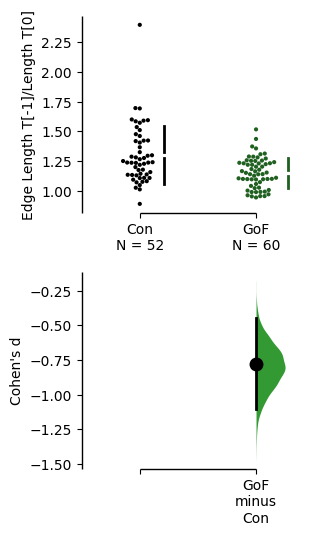

In [28]:
color_pal={'Con':'black', 'GoF': 'green'}
edge_avg_dabest.cohens_d.plot(swarm_label='Edge Length T[-1]/Length T[0]',float_contrast=False, custom_palette=color_pal, raw_marker_size=3);

In [39]:
ConGoF_meng = []
GoF_meng = []
ConGoF_names = []
GoF_names = []

key_hole = list(edge_curvature_dict.keys())
for k in range(len(key_hole)):
    if key_hole[k].split('_')[-2]=='Con':
        ConGoF_meng.append(np.nanmean(np.absolute(np.concatenate(edge_curvature_dict[key_hole[k]]))))
        ConGoF_names.append(key_hole[k])
    elif key_hole[k].split('_')[-2]=='GoF':
        GoF_meng.append(np.nanmean(np.absolute(np.concatenate(edge_curvature_dict[key_hole[k]]))))
        GoF_names.append(key_hole[k])
    else:
        print(key_hole[k])
        raise ValueError('Genotype mismatch')

In [40]:
GoF_meng_avg_df = pd.concat([pd.DataFrame(ConGoF_meng, columns=['Con']),
                      pd.DataFrame(GoF_meng, columns=['GoF'])], axis=1)
meng_avg_dabest = dabest.load(GoF_meng_avg_df, idx=("Con", "GoF"), resamples=5000)
meng_avg_dabest.cohens_d

C:\Users\17605\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\17605\AppData\Roaming\Python\Python37\site-packages\dabest\_classes.py:792: UserWarning: The lower limit of the BCa interval cannot be computed. It is set to the effect size itself. All bootstrap values were likely all the same.
  stacklevel=0)
C:\Users\17605\AppData\Roaming\Python\Python37\site-packages\dabest\_classes.py:797: UserWarning: The upper limit of the BCa interval cannot be computed. It is set to the effect size itself. All bootstrap values were likely all the same.
  stacklevel=0)


DABEST v0.3.1
             
Good evening!
The current time is Fri Jun 17 21:55:18 2022.

The unpaired Cohen's d between Con and GoF is nan [95%CI nan, nan].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

In [42]:
GoF_meng_avg = pd.concat([pd.DataFrame(ConGoF_name, columns=['Filename']),
                        pd.DataFrame(ConGoF_meng, columns=['Con']),
                        pd.DataFrame(GoF_name, columns=['Filename']),
                        pd.DataFrame(GoF_meng, columns=['GoF'])], axis=1)
date = datetime.now().strftime("%Y_%m_%d_")
GoF_meng_avg.to_excel(f'{date}Con&GoF_Meng_Avg.xlsx')

AttributeError: 'DataFrame' object has no attribute 'difference'

C:\Users\17605\.conda\envs\piv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



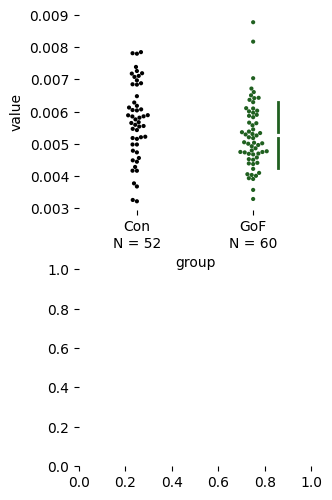

In [112]:
color_pal={'Con':'black', 'GoF': 'green'}
meng_avg_dabest.cohens_d.plot(swarm_label='Edge Length T[-1]/Length T[0]',float_contrast=False, custom_palette=color_pal, raw_marker_size=3);

In [119]:
all_edge_avg = pd.concat([pd.DataFrame(Con_cKO_edge_last, columns=['Control(cKO)']),
                        pd.DataFrame(cKO_edge_last, columns=['cKO']),
                        pd.DataFrame(ConGoF_edge_last, columns=['Control(GoF)']),
                        pd.DataFrame(GoF_edge_last, columns=['GoF']),
                        pd.DataFrame(DMSO_edge_last, columns=['DMSO']),
                        pd.DataFrame(Yoda1_edge_last, columns=['Yoda1'])], axis=1)


In [120]:
all_edge_avg_dabest = dabest.load(all_edge_avg, idx = (("Control(cKO)", "cKO"),
                                                       ("Control(GoF)", "GoF"),
                                                      ("DMSO", "Yoda1")), resamples=5000)
all_edge_avg_dabest.cohens_d

DABEST v0.3.1
             
Good morning!
The current time is Tue Jun 28 09:16:27 2022.

The unpaired Cohen's d between Control(cKO) and cKO is 0.598 [95%CI 0.233, 0.952].
The p-value of the two-sided permutation t-test is 0.0012. 

The unpaired Cohen's d between Control(GoF) and GoF is -0.799 [95%CI -1.18, -0.412].
The p-value of the two-sided permutation t-test is 0.0. 

The unpaired Cohen's d between DMSO and Yoda1 is -0.873 [95%CI -1.27, -0.416].
The p-value of the two-sided permutation t-test is 0.0002. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

C:\Users\17605\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:1296: UserWarning:

10.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

C:\Users\17605\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:1296: UserWarning:

10.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

C:\Users\17605\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:1296: UserWarning:

10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

C:\Users\17605\.conda\envs\piv\lib\site-packages\ipykernel_launcher.py:4: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

C:\Users\17605\.conda\envs\piv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might 

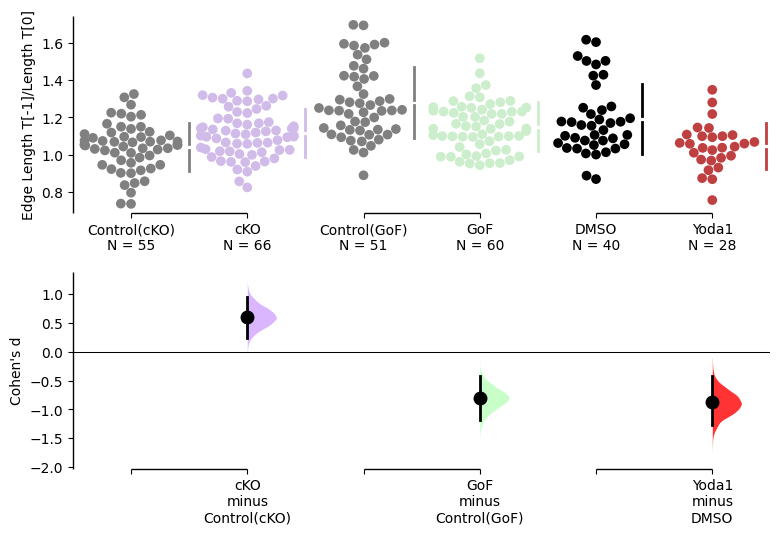

In [121]:
from matplotlib import pyplot as plt
color_pal = {'Control(cKO)':'grey', 'cKO': '#d1a4ff', 'Control(GoF)':'grey', 'GoF': '#bbffbb', 'DMSO':'black', 'Yoda1': 'red'}
edge_plot = all_edge_avg_dabest.cohens_d.plot(swarm_label='Edge Length T[-1]/Length T[0]',float_contrast=False, custom_palette=color_pal, raw_marker_size=7);
plt.savefig("edge_plot.svg")